In [24]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta, Adagrad, Nadam
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from tensorflow.keras.utils import to_categorical

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
train_path = "/content/drive/MyDrive/Human Emotion Classification/train"
test_path = "/content/drive/MyDrive/Human Emotion Classification/test"

seed = 12
img_height = 100
img_width = 100
batch_size = 16
epoch = 20
fine_tuning_epoch = 20
lr = 0.0001
num_classes = 3
early_stopping_criteria = 3
class_labels = ['angry', 'happy', 'sad']

In [27]:
preproces_fun = tf.keras.applications.efficientnet.preprocess_input
# Inisialisasi generator untuk augmentasi data
datagen_train = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split = 0.2,
    preprocessing_function = preproces_fun
)

datagen_test = ImageDataGenerator(rescale=1./255,
                                  preprocessing_function = preproces_fun)
# Persiapkan data generator untuk pelatihan
train_generator = datagen_train.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed,
    shuffle = True,
    color_mode = "rgb",
    subset = 'training'
)
validation_generator = datagen_train.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed,
    shuffle = True,
    color_mode = "rgb",
    subset = 'validation'
)
# Persiapkan data generator untuk pengujian
test_generator = datagen_test.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode="rgb",
    seed=seed
)

Found 1826 images belonging to 3 classes.
Found 455 images belonging to 3 classes.
Found 569 images belonging to 3 classes.


Found 2281 images belonging to 3 classes.


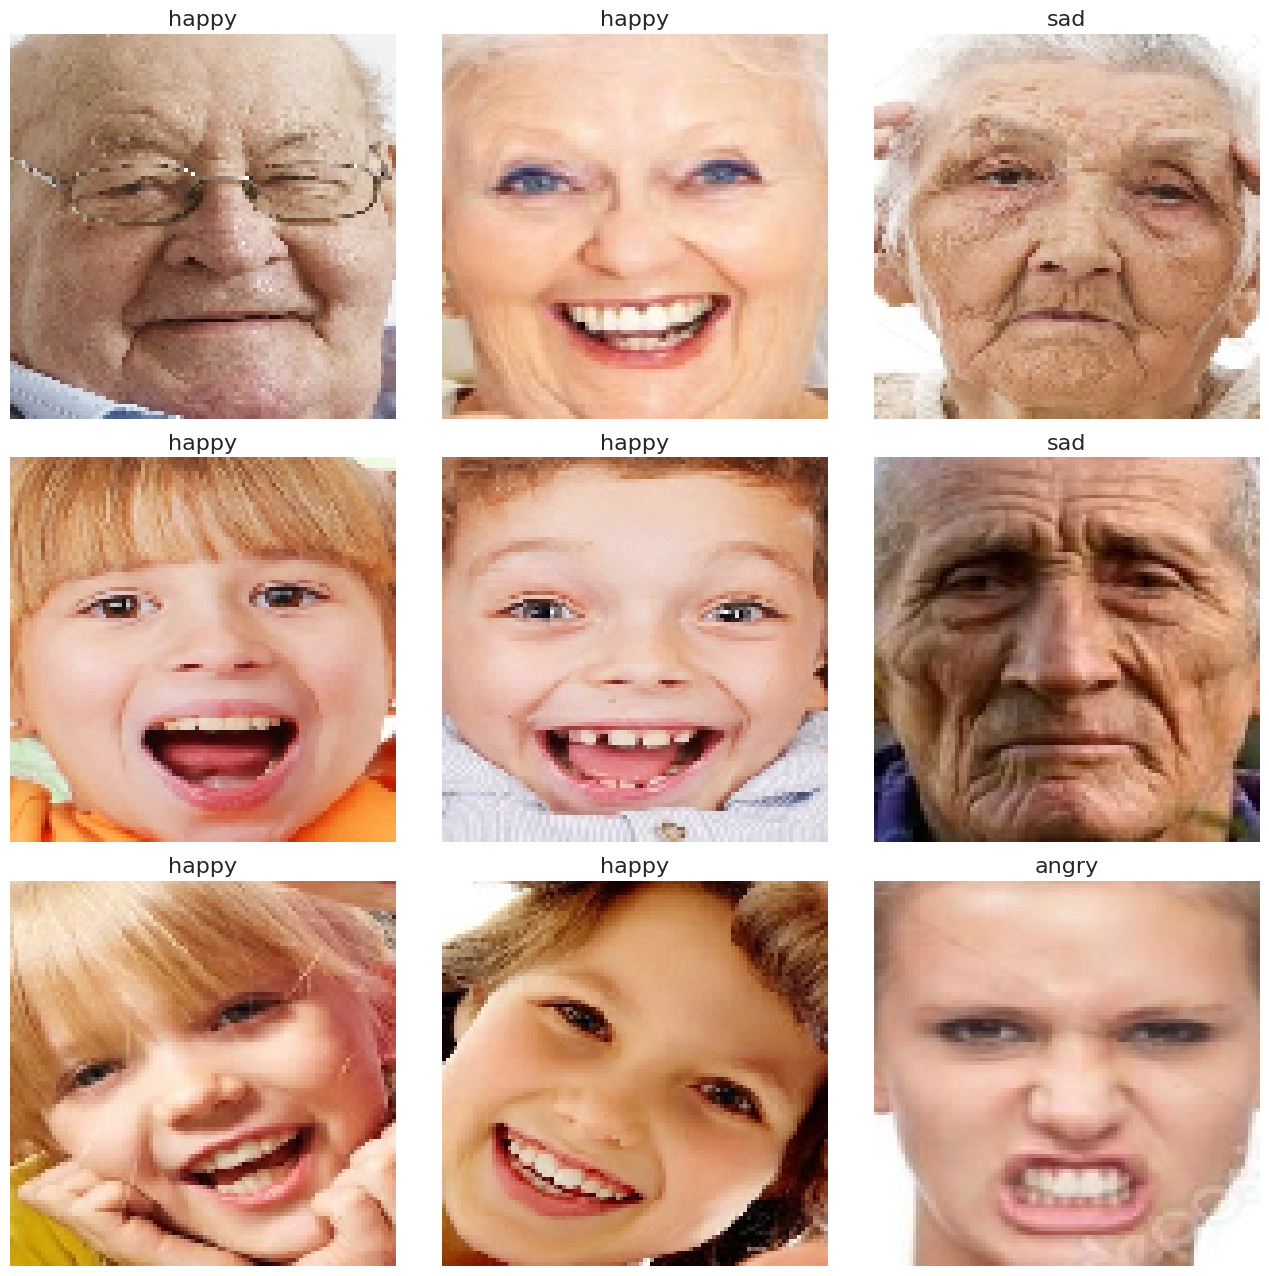

In [28]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)

def display_nine_images(images, titles, title_colors=None):
    plt.figure(figsize=(13, 13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
    # Both prediction (probabilities) and Label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{class_labels[prediction_idx]} [correct]', 'black'
    else:
        return f'{class_labels[prediction_idx]} [incorrect, should be {class_labels[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(labels, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

# img_datagen = ImageDataGenerator(rescale=1./255)  # Uncomment this line if you want to use rescaling
img_datagen = ImageDataGenerator(rescale=1./255)
img_generator = img_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    color_mode="rgb",
    seed=12
)

# Example: Display nine images with their titles and colors
images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=1)
labels = [class_labels[idx] for idx in class_idxs]
display_nine_images(images, labels)


In [29]:
def feature_extractor(inputs):
    nasnet_feature_extractor = EfficientNetB5(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights="imagenet"
    )(inputs)
    return nasnet_feature_extractor

def classifier(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):
    nasnet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(nasnet_feature_extractor)
    return classification_output

def define_compile_model():
    inputs = Input(shape=(img_height, img_width, 3))
    classification_output = final_model(inputs)
    model = Model(inputs=inputs, outputs=classification_output)

    # Compile the model
    model.compile(
        optimizer=RMSprop(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Check the model summary
model = define_compile_model()
model.summary()

115263384/115263384 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 efficientnetb5 (Functional  (None, 4, 4, 2048)        28513527  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                          

In [30]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=early_stopping_criteria,
                                                           verbose=1,
                                                           restore_best_weights=True)
history = model.fit(x = train_generator,
                    epochs = epoch,
                    validation_data = validation_generator,
                    callbacks = [early_stopping_callback])
history = pd.DataFrame(history.history)

Epoch 1/20
115/115 [==============================] - 93s 261ms/step - loss: 14.2236 - accuracy: 0.4009 - val_loss: 12.8596 - val_accuracy: 0.3736
Epoch 2/20
115/115 [==============================] - 24s 211ms/step - loss: 11.5379 - accuracy: 0.5055 - val_loss: 10.5826 - val_accuracy: 0.3692
Epoch 3/20
115/115 [==============================] - 23s 196ms/step - loss: 9.2663 - accuracy: 0.5931 - val_loss: 8.6218 - val_accuracy: 0.2703
Epoch 4/20
115/115 [==============================] - 24s 212ms/step - loss: 7.3741 - accuracy: 0.6572 - val_loss: 6.7194 - val_accuracy: 0.5385
Epoch 5/20
115/115 [==============================] - 22s 191ms/step - loss: 5.8117 - accuracy: 0.7076 - val_loss: 5.3860 - val_accuracy: 0.5714
Epoch 6/20
115/115 [==============================] - 22s 195ms/step - loss: 4.6183 - accuracy: 0.7185 - val_loss: 4.2161 - val_accuracy: 0.6440
Epoch 7/20
115/115 [==============================] - 25s 216ms/step - loss: 3.6597 - accuracy: 0.7333 - val_loss: 3.4852 - va

In [31]:
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])


# Selama model.fit
history_ = model.fit(x=train_generator, epochs=fine_tuning_epoch, validation_data=validation_generator)

# Setelah model.fit
history = history.append(pd.DataFrame(history_.history), ignore_index=True)


Epoch 1/20
115/115 [==============================] - 88s 237ms/step - loss: 0.5590 - accuracy: 0.8499 - val_loss: 1.1363 - val_accuracy: 0.6593
Epoch 2/20
115/115 [==============================] - 23s 202ms/step - loss: 0.5168 - accuracy: 0.8554 - val_loss: 1.0935 - val_accuracy: 0.6615
Epoch 3/20
115/115 [==============================] - 26s 226ms/step - loss: 0.4992 - accuracy: 0.8587 - val_loss: 1.0498 - val_accuracy: 0.6813
Epoch 4/20
115/115 [==============================] - 22s 193ms/step - loss: 0.4598 - accuracy: 0.8631 - val_loss: 0.9890 - val_accuracy: 0.6923
Epoch 5/20
115/115 [==============================] - 23s 198ms/step - loss: 0.4352 - accuracy: 0.8812 - val_loss: 1.1063 - val_accuracy: 0.7099
Epoch 6/20
115/115 [==============================] - 25s 214ms/step - loss: 0.4303 - accuracy: 0.8691 - val_loss: 0.9884 - val_accuracy: 0.7099
Epoch 7/20
115/115 [==============================] - 23s 196ms/step - loss: 0.4226 - accuracy: 0.8740 - val_loss: 1.1612 - val_ac

<ipython-input-31-8710065387c1>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [32]:
x = px.line(data_frame= history, y= ["accuracy", "val_accuracy"],markers = True )
x.update_xaxes (title="Number of Epochs")
x.update_yaxes (title = "Accuracy")
x.update_layout (showlegend = True,
title = {
'text': 'Accuracy vs Number of Epochs',
'y' :0.94,
'x': 0.5,
'xanchor': 'center',
'yanchor': 'top'})
x.show()

In [33]:
x = px.line(data_frame= history,
y= ["loss", "val_loss"], markers = True )
x.update_xaxes (title="Number of Epochs")
x.update_yaxes (title = "Loss")
x.update_layout (showlegend = True,
title = {
'text': 'Loss vs Number of Epochs',
'y' :0.94,
'x':0.5,
'xanchor': 'center',
'yanchor': 'top'})
x.show()

In [34]:
model.evaluate(test_generator)
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis = 1)
y_test = np.array(test_generator.labels)

36/36 [==============================] - 5s 40ms/step


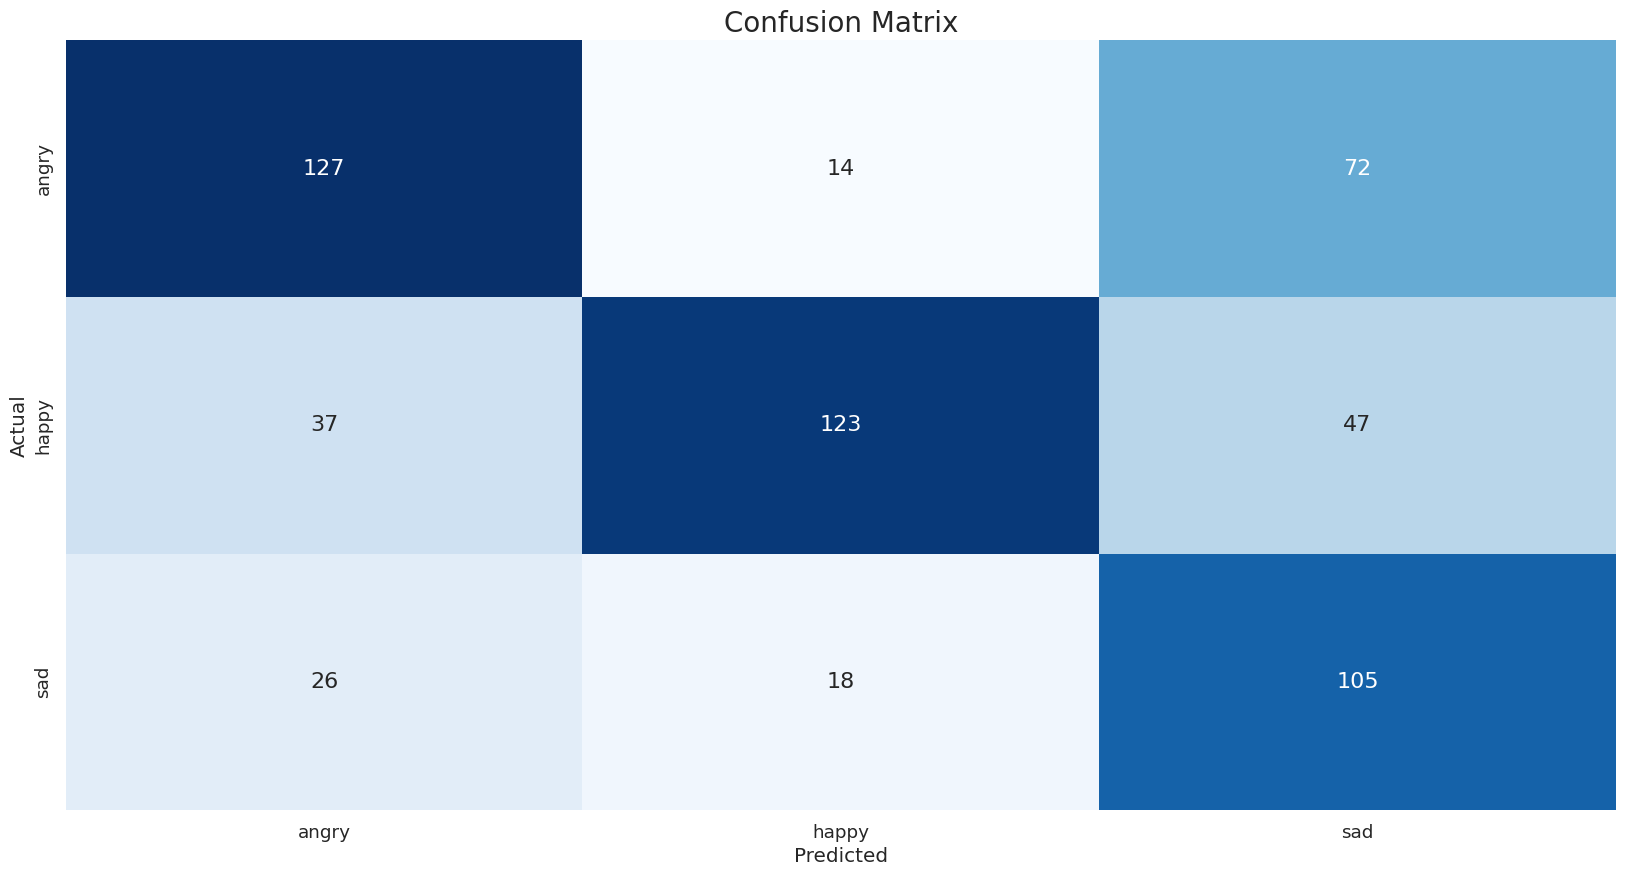

In [35]:
cm_data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame (cm_data, columns=class_labels, index = class_labels)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63       213
           1       0.79      0.59      0.68       207
           2       0.47      0.70      0.56       149

    accuracy                           0.62       569
   macro avg       0.64      0.63      0.62       569
weighted avg       0.66      0.62      0.63       569



ROC AUC score: 0.8137414636105027


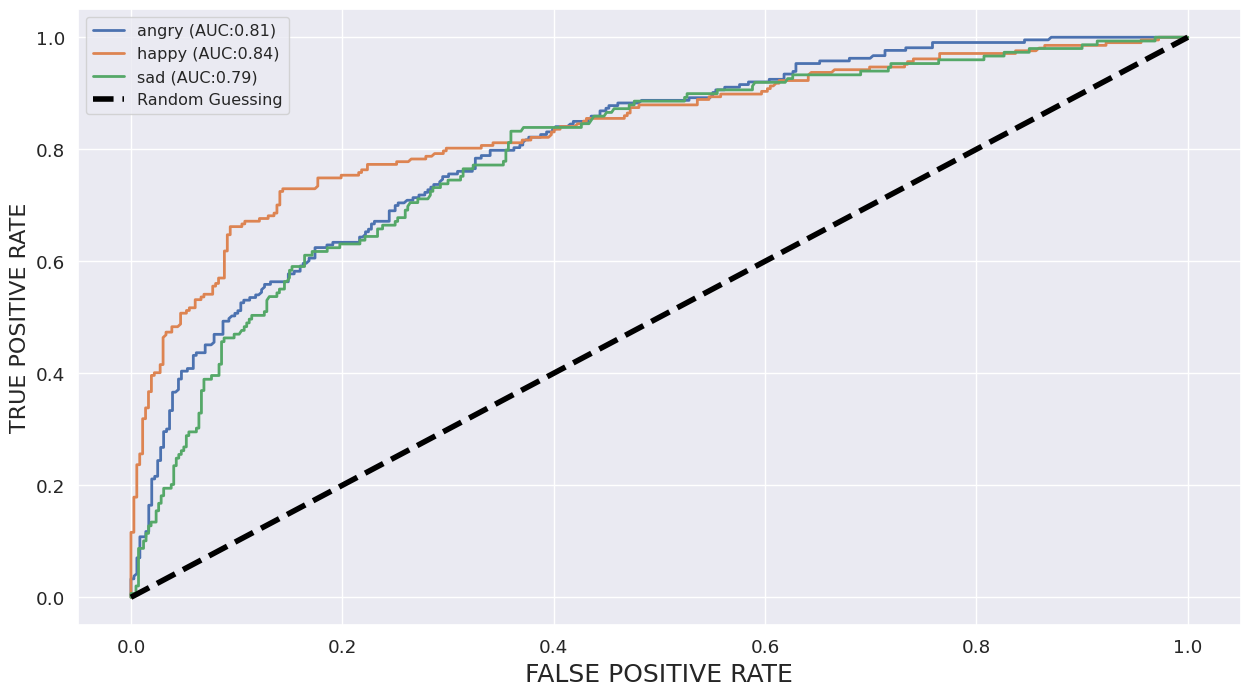

In [37]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(class_labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [38]:
print('ROC AUC SCORE = ', roc_auc_score(to_categorical(y_test), pred))

ROC AUC SCORE =  0.8129650354101235
